# Initialization

## Importing necessary packages

In [1]:
import os
import sys

BASE_DIR: str = '/teamspace/studios/this_studio/Prostate_Cancer_Grade_Assessment'
sys.path.append(os.path.join(BASE_DIR, 'code'))

import datetime
import random
import pandas as pd
import numpy as np
import PIL.Image as Image
import skimage.io
import torch
import torch.nn as nn
import torch.utils.data as D
import torchvision.transforms as transforms
import torchvision.models as models
import lightning as L
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

import yaml

from models.enet_models import EfficientNetModel
from hyperparameters import HyperParameters
from lightning_module import LightningModel
from data_module import PandaDataModule, TileDataset
from tqdm import tqdm_notebook as tqdm
from visual_helpers import get_clipping_bounds, create_tiles, create_big_image_from_tiles

from typing import List, Tuple, Dict

## Parameters

In [2]:
NUM_WORKERS: int = 4
LEVEL_DIMS: int = 1
NUM_TILES: int = 36
TILE_SIZE: int = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Input Data Source

In [3]:
TRAINING_DATA_FOLDER: str = 'train-closetiled-prostate-36x256x256'
TESTING_DATA_FOLDER: str = 'test-closetiled-prostate-36x256x256'
DATASET_FOLDER_PATH: str = os.path.join(BASE_DIR, 'dataset')
TESTING_DATA_CSV_PATH: str = os.path.join(DATASET_FOLDER_PATH, TESTING_DATA_FOLDER, 'test.csv')

PANDA_DATASET_NAME: str = 'prostate-cancer-grade-assessment'
PANDA_DATASET_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, PANDA_DATASET_NAME)
PANDA_IMAGE_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_images')
PANDA_MASKS_FOLDER_PATH: str = os.path.join(PANDA_DATASET_FOLDER_PATH, 'train_label_masks')

# Trained Model checkpoint

Setting the file paths for the trained model checkpoint and the hyperparameters `.yaml` file

In [4]:
# chkpt_file_path: str = '/teamspace/studios/this_studio/trained_models/cls_effnet_b0_Rand36r36tiles256_big_bce_lr0.3_augx2_30epo_model_fold0.pth'
chkpt_file_path = '/teamspace/studios/this_studio/trained_models/efficientnet-b0-20240425-114106/fold_0.pth'
hparams_file_path: str = '/teamspace/studios/this_studio/logs/efficientnet-b0-20240425-114106/fold_1/hparams.yaml'

# Loading the saved HyperParameters `.yaml` file
dict_h_params: Dict[str, any] = {}
with open(hparams_file_path, 'r') as stream:
    dict_yaml = yaml.safe_load(stream)
    dict_h_params = dict_yaml

# Instantiating a HyperParameters object
h_params = HyperParameters.load_from_dict(dict_h=dict_h_params)

# EfficientNet Model

In [5]:
# Initializing the EfficientNet model architecture
model = EfficientNetModel(c_out=h_params.c_out,
                          backbone=h_params.backbone)

print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNetModel(
  (enet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )

# Model Predictions

## Predictions on the complete Hold-out Test set

### Testing Data

In [6]:
# Load the `test.csv` file from the Hold-out test set
df_testing_data : pd.DataFrame = pd.read_csv(TESTING_DATA_CSV_PATH)

df_testing_data

,image_id,data_provider,isup_grade,gleason_score
0,332db6f0f6f290e521b714b4d209ff25,karolinska,2,3+4
1,9a3ad5844e796a97e725de8fa7518144,radboud,2,3+4
2,be9a4ad52349a7a82f4e8ac2154e93df,karolinska,3,4+3
3,345f3e86a3dcc26dce73ceeacc5a4a0a,radboud,3,4+3
4,6de4998fbdf6ebd012fd6b727890e582,karolinska,1,3+3
...,...,...,...,...
990,e9c567814f3d582607f9eff2a3b7668c,karolinska,0,0+0
991,a4119823dddda4b7cd9be59893173b0a,karolinska,0,0+0
992,9b16f18bbaecf31ae19380009a076862,radboud,5,4+5
993,af48aa2477b1f92d2b98a6eb6993873f,karolinska,1,3+3


### DataLoader

In [7]:
# Setting the path for the tiled dataset containing images for testing
TESTING_DATA_IMAGES_FOLDER_PATH: str = os.path.join(DATASET_FOLDER_PATH, TESTING_DATA_FOLDER, 'images')

# Creating a the dataset to serve the dataloader
dataset_test = TileDataset(TESTING_DATA_IMAGES_FOLDER_PATH,
                           df_testing_data,
                           h_params.num_tiles, h_params.num_tiles_select,
                           h_params.tile_size, h_params.is_big_image_tile,
                           None, None)
# Setting up the Testing dataloader
test_loader = D.DataLoader(dataset=dataset_test,
                           batch_size=h_params.batch_size,
                           drop_last=False,
                           shuffle=False,
                           num_workers=NUM_WORKERS)

### Testing Function

In [8]:
def predict_test_data(model, data_loader, input_img: np.ndarray=[], target: np.ndarray=[]):
    testing_loss: float = 0.0
    list_test_loss: List[float] = []
    list_predictions: List[np.ndarray] = []
    list_targets: List[np.ndarray] = []

    # Loss function
    bce_logits_loss = nn.BCEWithLogitsLoss()

    model.eval()
    with torch.no_grad():
        if data_loader:
            for x in tqdm(data_loader):
                input_image = x['image'].to(torch.device(DEVICE))
                target = x['target'].to(torch.device(DEVICE))
                logits = model(input_image)

                loss = bce_logits_loss(logits, target)
                prediction = logits.sigmoid().sum(1).detach().round()
                target = target.sum(1)

                list_predictions.append(prediction)
                list_targets.append(target)

                list_test_loss.append(loss.detach().cpu().numpy())
        else:
            input_image = input_img.to(torch.device(DEVICE))
            target = target.to(torch.device(DEVICE))
            logits = model(input_image)

            loss = bce_logits_loss(logits, target)
            prediction = logits.sigmoid().sum(1).detach().round()
            target = target.sum(1)

            list_predictions.append(prediction)
            list_targets.append(target)

            list_test_loss.append(loss.detach().cpu().numpy())

    testing_loss = np.mean(list_test_loss)
    arr_predictions = torch.cat(list_predictions).cpu().numpy()
    arr_targets = torch.cat(list_targets).cpu().numpy()
    kappa = cohen_kappa_score(arr_predictions, arr_targets, weights='quadratic')

    return list_predictions, list_targets, testing_loss, kappa

### Testing Results on the complete Holdout Test set

In [9]:
# Loading the trained model weights
model.to(torch.device(DEVICE))
model.load_state_dict(torch.load(chkpt_file_path, map_location=torch.device(DEVICE)))

# Running predictions on the testing set
arr_predictions, arr_targets, test_loss, kappa = predict_test_data(model=model, data_loader=test_loader)
print(f'Testing Dataset: {TESTING_DATA_FOLDER}')
print(f'Testing Loss: {test_loss}, Kappa (Cohen-Kappa score): {kappa}')

/tmp/ipykernel_9537/2849943650.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x in tqdm(data_loader):


  0%|          | 0/249 [00:00<?, ?it/s]

## Prediction on a single image

### Selecting a random image

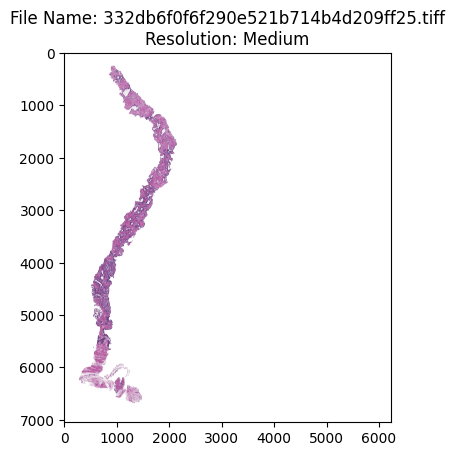

In [ ]:
random_idx: int = random.randint(0, len(df_testing_data))
random_idx = 0
df_row: pd.Series = df_testing_data.iloc[random_idx]

# Loading the original testing image (.tiff) file 
test_image: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_IMAGE_FOLDER_PATH, f'{df_row.image_id}.tiff'))[LEVEL_DIMS]
test_mask: np.ndarray = skimage.io.ImageCollection(os.path.join(PANDA_MASKS_FOLDER_PATH, f'{df_row.image_id}_mask.tiff'))[LEVEL_DIMS]

# Displaying the original testing image (.tiff)
plt.figure()
plt.imshow(test_image)
plt.title(f'File Name: {df_row.image_id}.tiff\nResolution: Medium')
plt.show()

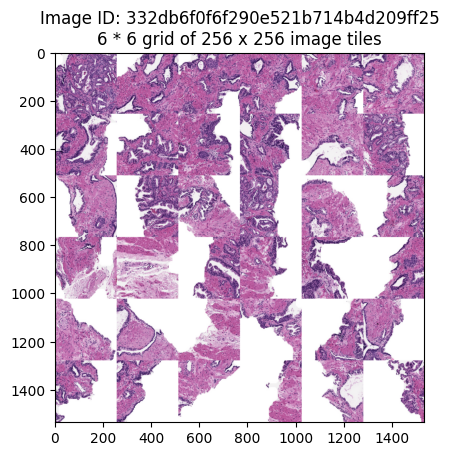

In [ ]:
# Clipping the image (to reduce white space around the ROI)
x_b, y_b = get_clipping_bounds(test_image, perform_thresholding=True)
img_clipped = test_image[x_b[0]:x_b[1], y_b[0]:y_b[1]]
mask_clipped = test_mask[x_b[0]:x_b[1], y_b[0]:y_b[1]]

# Creating image tiles from the input testing image
tiles = create_tiles(img_clipped, mask_clipped, NUM_TILES, TILE_SIZE)

# Creating a big image from the tiles
big_image: np.ndarray = create_big_image_from_tiles(tiles, NUM_TILES, TILE_SIZE).astype(np.uint8)

plt.figure()
plt.imshow(big_image)
plt.title(f'Image ID: {df_row.image_id}\n6 * 6 grid of 256 x 256 image tiles')
plt.show()

In [ ]:

# Take the model's output for the input image


# Calculate scores comparing the predicted and target outputs
big_image /= 255
big_image = big_image.astype(np.float32)
big_image = big_image.transpose(2, 0, 1)

label = np.zeros(5).astype(np.float32)
label[:df_row.isup_grade] = 1.

_, _, lossss, kapppppaa = predict_test_data(model=model, data_loader=None,
                                            input_img=torch.tensor(big_image),
                                            target=torch.tensor(label))






RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1536, 1537, 4] to have 3 channels, but got 1536 channels instead

# Current Approach

I. Data Preparation:
- Excluding suspicious images with pen marks, missing labels/masks, etc
- Using Medium resolution (level=1) from every TIFF image
- Cropping the image closesly using thresholding to reduce white space (before tiling)
- Tiling to obtain 36 square image tiles of size 256 x 256 from every TIFF file (choosing top 36 tiles with the highest tissue content)
- Splitting the data to reserve 10% of the data for testing; 90% for training + validation

II. Model:
- EfficientNet B0
- Using pre-trained encoder weights trained on ImageNet V1 dataset
- Input: N x N large image created from 36 tiles
- Output: 5 outputs (Label binning)

III. Training Strategy
- Training for 40 epochs on 36 x 256 x 256 tiled dataset (without close clipping)
    - Training from scratch
    - Augmentations (Large image): Horizontal Flipping, Vertical Flipping
- Finetuning for 20-30 epochs on 36 x 256 x 256 tiled dataset (with close clipping)
    - Training using previous model checkpoint
    - Augmentations (Big image): Horizontal Flipping, Vertical Flipping
    - Augmentations (Tile)     : Horizontal Flipping, Vertical Flipping, Random Rotation
    - Replacing majorly white tiles (Coverage < 10 percent) by randomly sampling from the remaining tiles for an image


# Past Approaches

1. Training a model without tiling the PANDA dataset (1 images per TIFF)
    - Creating 512 x 512 square images by closely clipping images of median resolution (level=1)
    - Issues: Artifacts in the slide images skewed for rectangular images; unnaturally larger or smaller
    - Models tried with: ResNet50, ResNeXt50 (with pre-trained weights)
2. Tiling to create 16 x 128 x 128 image dataset (16 images per TIFF)
    - Creating 128 x 128 square images by tiling over images of the lowest resolution (level=2)
    - Issues: Blurry images; Artifacts not clearly visible
3. Tiling to create 36 x 256 x 256 image datasets (36 images per TIFF)
    - Advantages: Image tiles represent the microscopy slide better with no skew/blurriness
    - Disadvantages: Local GPU training not possible; Low batch size with online VM environment
    - Models tried with: ResNet50, ResNeXt50, EfficientNet B0 (with pre-trained weights)

# Experimental Future Approaches

1. Creating 2 datasets for square and rectangular TIFF images
    - Creating 1 image per TIFF image for a square/rectangular image
    - Zero or white padding to make it a square image
    - 2 separate classifier models to train on each dataset 

2. Training with target as the `gleason_score` instead of `isup_grade`
    - Input images will be an (N x 256) x (N x 256) image
    - Target output will be a vector of 2 values (gleason scores) for each tile
    - If N = 6, target output vector will be 6 x 6 x 2
    - Calculating the `isup_grade` value from the `gleason_score` predicted by the model

3. Segmentation + Classification approach
    - Model 1: Semantic Segmentation model to generate target masks
    - Model 2: Classifier model producing the target score based on an input mask
    - Advantage: Classifying prostate cancer from the target mask will be easier owing to the reduced dimensionality of the data
                 Performance will largely depend on the IoU of the segmentation model
    